Evaluating Persistence:   0%|          | 0/5 [00:00<?, ?zone/s]

Evaluating SARIMA:   0%|          | 0/5 [00:00<?, ?zone/s]

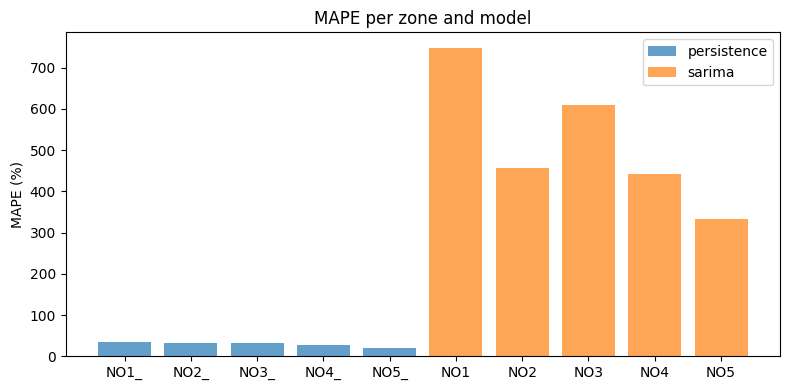

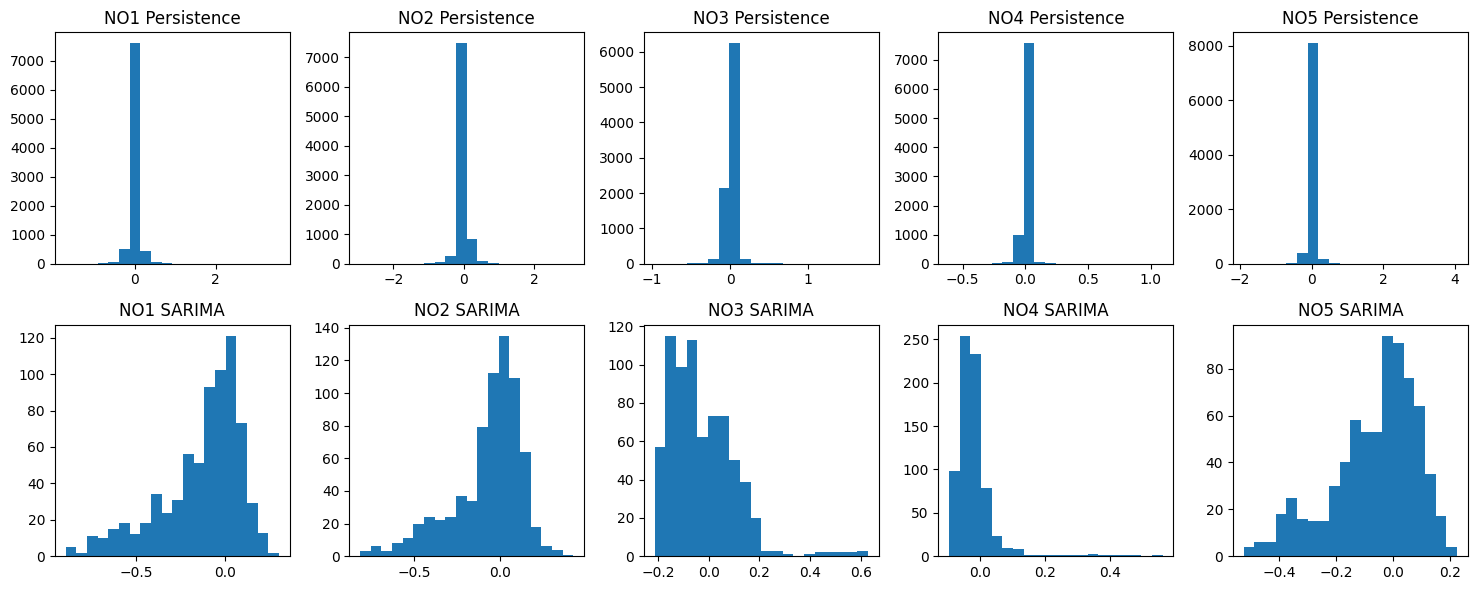

In [2]:
# notebooks/03_model_baseline.ipynb

# Baseline Model Comparison

"""
This notebook compares the persistence model and a SARIMA model
using MAE, RMSE, and MAPE across all five price zones.
"""

# 1. Setup
import os, sys
from tqdm.notebook import tqdm
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path     = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Model imports
from models.train_persistence import load_data as load_persistence_data, persistence_predict
from models.train_arima    import load_series, train_test_split, fit_sarima, forecast_sarima

# 2. Load Data
features_path = os.path.join(project_root, "data", "processed", "features.csv")
labels_path   = os.path.join(project_root, "data", "processed", "labels.csv")
X_persist, y_persist = load_persistence_data(features_path, labels_path)
zones = [c.replace("_label", "") for c in y_persist.columns]

pred_persist = persistence_predict(X_persist, zones)
metrics_persist = {}
for zone in tqdm(zones, desc="Evaluating Persistence", unit="zone"):
    true = y_persist[f"{zone}_label"].values
    pred = pred_persist[f"{zone}_pred"].values
    mask = (~pd.isna(true)) & (true != 0)
    mae  = mean_absolute_error(true[mask], pred[mask])
    rmse = np.sqrt(mean_squared_error(true[mask], pred[mask]))
    mape = (np.abs((true[mask] - pred[mask]) / true[mask]).mean() * 100)
    metrics_persist[zone] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# SARIMA‐evaluering med progress bar
metrics_sarima = {}
for zone in tqdm(zones, desc="Evaluating SARIMA", unit="zone"):
    series = load_series(zone, "../data/interim/clean_prices.csv")
    train, test = train_test_split(series)
    model_fit = fit_sarima(train, order=(1,0,1), seasonal_order=(1,1,1,24))
    preds = forecast_sarima(model_fit, len(test), test.index[0])
    true = test.values
    pred = preds
    mask = (~pd.isna(true)) & (true != 0)
    mae  = mean_absolute_error(true[mask], pred[mask])
    rmse = np.sqrt(mean_squared_error(true[mask], pred[mask]))
    mape = (np.abs((true[mask] - pred[mask]) / true[mask]).mean() * 100)
    metrics_sarima[zone] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# 5. Compile Results
df_p = pd.DataFrame.from_dict(metrics_persist, orient="index")
df_p["model"] = "persistence"

df_a = pd.DataFrame.from_dict(metrics_sarima, orient="index")
df_a["model"] = "sarima"

df_all = pd.concat([df_p, df_a]).reset_index().rename(columns={"index": "zone"})

# 6. Plot MAPE Comparison
plt.figure(figsize=(8,4))
for m in ["persistence", "sarima"]:
    sub = df_all[df_all.model == m]
    plt.bar(sub.zone + ("_" if m == "persistence" else ""), sub.MAPE, alpha=0.7, label=m)
plt.legend()
plt.title("MAPE per zone and model")
plt.ylabel("MAPE (%)")
plt.tight_layout()
plt.show()

# 7. Residual Histograms
fig, axes = plt.subplots(2, len(zones), figsize=(15,6))
for i, zone in enumerate(zones):
    # Persistence residuals
    res_p = y_persist[f"{zone}_label"] - pred_persist[f"{zone}_pred"]
    axes[0,i].hist(res_p.dropna(), bins=20)
    axes[0,i].set_title(f"{zone} Persistence")

    # SARIMA residuals
    series      = load_series(zone, os.path.join(project_root, "data", "interim", "clean_prices.csv"))
    train, test = train_test_split(series)
    model_fit   = fit_sarima(train, order=(1,0,1), seasonal_order=(1,1,1,24))
    pred_series = forecast_sarima(model_fit, len(test), test.index[0])
    res_a       = test - pred_series
    axes[1,i].hist(res_a.dropna(), bins=20)
    axes[1,i].set_title(f"{zone} SARIMA")

plt.tight_layout()
plt.show()
